<a href="https://colab.research.google.com/github/eugeneteoh/COMP6247-Reinforcement-Online-Learning/blob/master/lab_4/rbf_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [370]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [371]:
%matplotlib inline
import gym
from gym import wrappers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
from tqdm import tqdm

SEED = 0

sns.set()

# Running Gym Environment

In [372]:
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()
# env.render()

# Some initializations
#
n_states = 40
episodes = 1000
initial_lr = 1.0
min_lr = 0.005
gamma = 0.99
max_stps = 300
epsilon = 0.05
env = env.unwrapped
env.seed()
np.random.seed(0)
# Quantize the states
#
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled

ep_steps = np.zeros(episodes)
q_table = np.zeros((n_states, n_states, env.action_space.n))
total_steps = 0
for episode in tqdm(range(episodes)):
    # print("Episode:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    
    while True:
        # env.render()

        pos, vel = discretization(env, obs)
        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
        else:
            a = np.argmax(q_table[pos][vel])
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs)
        # Q function update
        #
        q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
        steps += 1

        if terminate:
            ep_steps[episode] = steps
            break
env.close()
# while True:
#     env.render()



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:05<1:27:51,  5.28s/it]

  0%|          | 2/1000 [00:05<1:02:11,  3.74s/it]

  0%|          | 3/1000 [00:05<44:11,  2.66s/it]  

  0%|          | 5/1000 [00:05<31:21,  1.89s/it]

  1%|          | 6/1000 [00:05<22:42,  1.37s/it]

  1%|          | 7/1000 [00:06<16:24,  1.01it/s]

  1%|          | 8/1000 [00:06<12:18,  1.34it/s]

  1%|          | 9/1000 [00:06<10:18,  1.60it/s]

  1%|          | 10/1000 [00:06<08:14,  2.00it/s]

  1%|          | 11/1000 [00:06<06:31,  2.53it/s]

  1%|▏         | 13/1000 [00:07<05:48,  2.83it/s]

  1%|▏         | 14/1000 [00:07<06:40,  2.46it/s]

  2%|▏         | 15/1000 [00:08<06:04,  2.70it/s]

  2%|▏         | 16/1000 [00:08<05:01,  3.26it/s]

  2%|▏         | 17/1000 [00:09<07:09,  2.29it/s]

  2%|▏         | 18/1000 [00:09<06:27,  2.54it/s]

  2%|▏         | 19/1000 [00:09<06:23,  2.56it/s]

  2%|▏         | 20/1000 [00:10<06:40,  2.44it/s]

  2%|▏         | 21/1000 [00:11<10:59,  

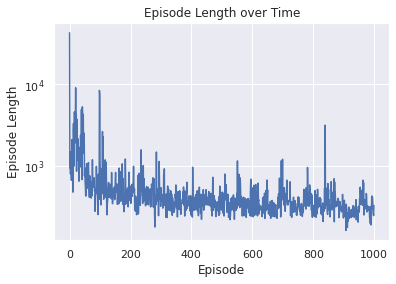

In [373]:
fig, ax = plt.subplots()
ax.plot(ep_steps)
ax.set_yscale('symlog')
ax.set(title="Episode Length over Time", xlabel="Episode", ylabel="Episode Length")
fig.savefig("ep_length.pdf")

In [374]:
# V*
V = np.max(q_table, axis=-1)

In [375]:
# plotting grids
env_low = env.observation_space.low
env_high = env.observation_space.high
pos_ = np.linspace(env_low[0], env_high[0], n_states)
vel_ = np.linspace(env_low[1], env_high[1], n_states)
pos_grid, vel_grid = np.meshgrid(pos_, vel_)

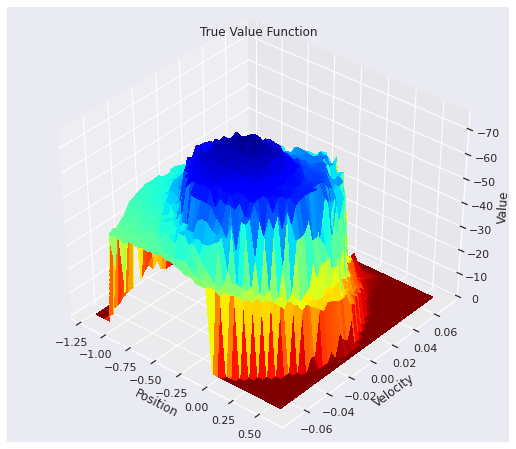

In [376]:
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d', elev=40, azim=-50)
ax.plot_surface(pos_grid, vel_grid, V, cmap=cm.jet, linewidth=0, antialiased=False)
ax.set_zlim(ax.get_zlim()[::-1])
ax.set(xlabel="Position", ylabel="Velocity", zlabel="Value", title="True Value Function")
fig.savefig("true_value_function.pdf")

# RBF Approximation

In [377]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

In [392]:
def gaussian_func(alpha):
    return np.exp(-alpha**2)

def design_matrix(X, J, sigma):
    N = X.shape[0]

    kmeans = KMeans(n_clusters=J, random_state=SEED).fit(X)
    M = kmeans.cluster_centers_

    U = np.zeros((N, J))
    for i in range(N):
        for j in range(J):
            U[i, j] = gaussian_func(np.linalg.norm(X[i] - M[j]) / sigma)

    return U

def rbf_approximation(X, J, Q, sigma):
    U = design_matrix(X, J, sigma)
    W = np.linalg.inv(U.T @ U) @ U.T @ Q.reshape(U.shape[0], -1)
    Q_hat = (U @ W).reshape(Q.shape)
    V_hat = np.max(Q_hat, -1)
    return Q_hat, V_hat

def plot_value_func(pos_grid, vel_grid, V, J):
    fig = plt.figure(figsize=(9,8))
    ax = fig.gca(projection='3d', elev=40, azim=-50)
    ax.plot_surface(pos_grid, vel_grid, V_hat, cmap=cm.jet, linewidth=0, antialiased=False)
    ax.set_zlim(ax.get_zlim()[::-1])
    ax.set(xlabel="Position", ylabel="Velocity", zlabel="Value", title=f"J = {J}")
    plt.show()

    return fig

def evaluate_Q(Q_hat):
    env_name = "MountainCar-v0"
    env = gym.make(env_name)
    env = env.unwrapped
    obs = env.reset()
    steps = 0
    for i in range(10000):
        pos, vel = discretization(env, obs)
        a = np.argmax(Q_hat[pos][vel])
        obs, reward, terminate,_ = env.step(a)
        steps += 1
        if terminate:
            break
    return steps



  0%|          | 0/40 [00:00<?, ?it/s]

(40, 2)




  2%|▎         | 1/40 [00:02<01:19,  2.03s/it]

  5%|▌         | 2/40 [00:02<00:55,  1.46s/it]

  8%|▊         | 3/40 [00:04<01:09,  1.87s/it]

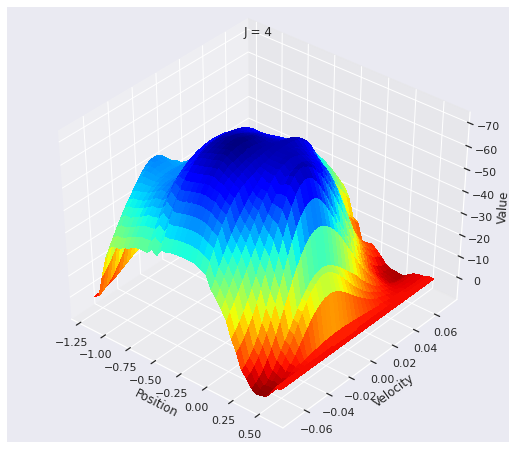



 10%|█         | 4/40 [00:05<00:52,  1.46s/it]

 12%|█▎        | 5/40 [00:05<00:37,  1.08s/it]

 15%|█▌        | 6/40 [00:05<00:27,  1.25it/s]

 18%|█▊        | 7/40 [00:05<00:19,  1.66it/s]

 20%|██        | 8/40 [00:06<00:14,  2.14it/s]

 22%|██▎       | 9/40 [00:06<00:12,  2.57it/s]

 25%|██▌       | 10/40 [00:06<00:09,  3.02it/s]

 28%|██▊       | 11/40 [00:06<00:08,  3.49it/s]

 30%|███       | 12/40 [00:07<00:08,  3.46it/s]

 32%|███▎      | 13/40 [00:07<00:06,  3.94it/s]

 35%|███▌      | 14/40 [00:07<00:06,  4.08it/s]

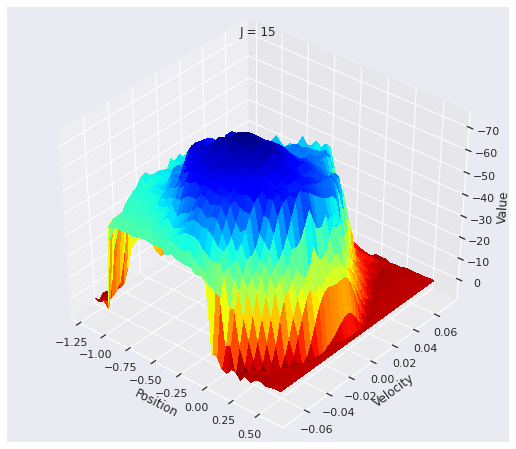



 38%|███▊      | 15/40 [00:07<00:08,  2.85it/s]

 40%|████      | 16/40 [00:08<00:07,  3.20it/s]

 42%|████▎     | 17/40 [00:13<00:40,  1.74s/it]

 45%|████▌     | 18/40 [00:18<01:00,  2.75s/it]

 48%|████▊     | 19/40 [00:23<01:11,  3.40s/it]

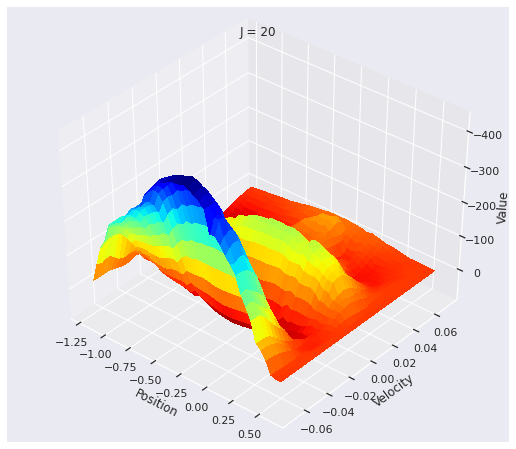



 50%|█████     | 20/40 [00:28<01:20,  4.04s/it]

 52%|█████▎    | 21/40 [00:29<00:55,  2.91s/it]

 55%|█████▌    | 22/40 [00:33<01:02,  3.50s/it]

 57%|█████▊    | 23/40 [00:39<01:07,  3.99s/it]

 60%|██████    | 24/40 [00:39<00:46,  2.89s/it]

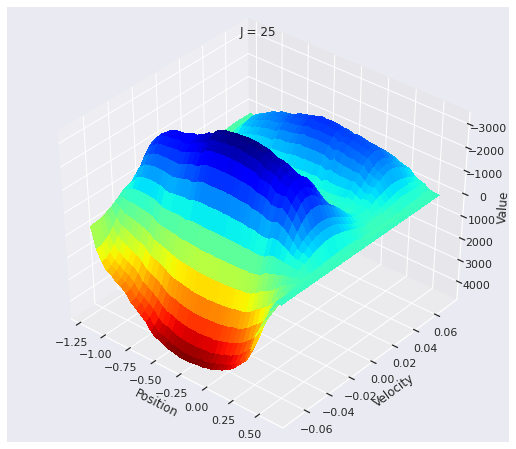



 62%|██████▎   | 25/40 [00:40<00:33,  2.22s/it]

 65%|██████▌   | 26/40 [00:40<00:23,  1.64s/it]

 68%|██████▊   | 27/40 [00:45<00:35,  2.74s/it]

 70%|███████   | 28/40 [00:45<00:24,  2.01s/it]

 72%|███████▎  | 29/40 [00:51<00:32,  2.92s/it]

 75%|███████▌  | 30/40 [00:55<00:35,  3.50s/it]

 78%|███████▊  | 31/40 [00:56<00:22,  2.55s/it]

 80%|████████  | 32/40 [01:01<00:26,  3.30s/it]

 82%|████████▎ | 33/40 [01:06<00:26,  3.76s/it]

 85%|████████▌ | 34/40 [01:06<00:16,  2.72s/it]

 88%|████████▊ | 35/40 [01:11<00:16,  3.39s/it]

 90%|█████████ | 36/40 [01:16<00:15,  3.96s/it]

 92%|█████████▎| 37/40 [01:20<00:12,  4.02s/it]

 95%|█████████▌| 38/40 [01:25<00:08,  4.33s/it]

 98%|█████████▊| 39/40 [01:30<00:04,  4.41s/it]

100%|██████████| 40/40 [01:35<00:00,  2.39s/it]


In [397]:
X = np.dstack([pos_, vel_]).reshape(n_states, 2)
print(X.shape)
sigma = np.std(X)

J_list = []
rbf_steps = []
rbf_mse = []
for J in tqdm(range(1, 40+1)):
# for J in [5, 15, 20]:
    Q_hat, V_hat = rbf_approximation(X, J, q_table, sigma)
    J_list.append(J) # just to keep track of J values
    rbf_mse.append(mean_squared_error(V, V_hat)) # track mse
    average_steps = np.mean([evaluate_Q(Q_hat) for _ in range(5)]) # take average due to stochasticity
    rbf_steps.append(average_steps) # track episode length

    if J in [4, 15, 20, 25]:
        fig = plot_value_func(pos_grid, vel_grid, V_hat, J)
        # fig.savefig(f"rbf_value_function_{J}.pdf")

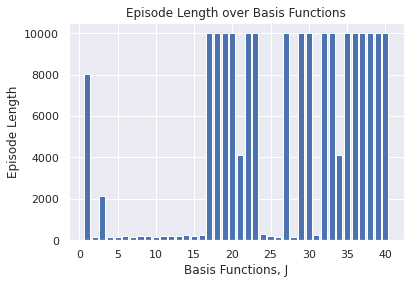

In [396]:
fig, ax = plt.subplots()
ax.bar(J_list, rbf_steps)
ax.set(xlabel="Basis Functions, J", ylabel="Episode Length", title="Episode Length over Basis Functions")
fig.savefig("ep_steps_j.pdf")

In [391]:
print(rbf_steps[15])
print(np.min([val for val in rbf_steps if val != 0]))

270.8
102.6


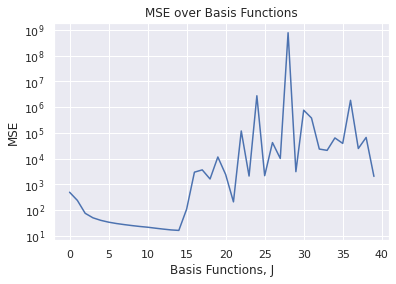

In [380]:
fig, ax = plt.subplots()
ax.plot(rbf_mse)
ax.set_yscale('symlog')
ax.set(xlabel="Basis Functions, J", ylabel="MSE", title="MSE over Basis Functions")
fig.savefig("mse_j.pdf")